In [2]:
import ast
from collections import defaultdict
from collections.abc import Iterator
import os
from typing import Mapping, NamedTuple, TextIO, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

BEST_CONCEPTS_FILENAME = "best_concepts.txt"
GENERATION_HISTORY_FILENAME = "generation_history.txt"
BEST_CONCEPT_KEY = "best_concept"
BEST_SCORE_KEY = "best_score"
SEPARATOR = ","

In [3]:
class Concept(NamedTuple):
    concept: str
    score: float


def get_result_filepaths(result_dir: str) -> Iterator[str]:
    for experiment_dir in os.listdir(result_dir):
        if experiment_dir.startswith("."):
            continue
        path = os.path.join(result_dir, experiment_dir)
        best_concepts_filepath = os.path.join(path, BEST_CONCEPTS_FILENAME)
        generation_history_filepath = os.path.join(
            path, GENERATION_HISTORY_FILENAME
        )

        yield best_concepts_filepath, generation_history_filepath


def get_first_best(best_concepts_file: TextIO) -> Concept:
    first_best_metadata = ast.literal_eval(
        best_concepts_file.readline().strip()
    )

    return Concept(
        first_best_metadata[BEST_CONCEPT_KEY],
        float(first_best_metadata[BEST_SCORE_KEY]),
    )


def process_generation_history_generated(
    generation_history_file: TextIO,
) -> Tuple[Sequence[float], int]:
    best_score = -float("inf")
    best_generation_iter = -1
    scores = []

    for iter, line in enumerate(generation_history_file.readlines(), 1):
        fields = line.split(SEPARATOR)
        if len(fields) != 2:
            raise ValueError("Invalid format of generation history.")

        _, score_string = fields
        score = float(score_string)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_generation_iter = iter

    return np.maximum.accumulate(scores), best_generation_iter


def process(
    best_concept_filepath: str, generation_history_filepath: str
) -> int:
    invalid_experiments_dir = not (
        os.path.isfile(best_concept_filepath)
        and os.path.isfile(generation_history_filepath)
    )
    if invalid_experiments_dir:
        raise ValueError("Invalid experiments directory.")

    with open(generation_history_filepath, "r") as generation_history_file:
        try:
            scores_cummax, best_generation_iter = (
                process_generation_history_generated(generation_history_file)
            )
        except ValueError:
            print(
                f"Invalid generation_hitory file: {generation_history_filepath}"
                " - Skipping this file."
            )
            scores_cummax = None
            best_generation_iter = -1

        return scores_cummax, best_generation_iter


def process_results(result_dir: str) -> Mapping[int, int]:
    best_concept_iterations = defaultdict(int)
    scores_cummax_matrix = []

    for (
        best_concept_filepath,
        generation_history_filepath,
    ) in get_result_filepaths(result_dir):
        try:
            scores_cummax, best_generation_iter = process(
                best_concept_filepath, generation_history_filepath
            )
            if scores_cummax is not None:
                scores_cummax_matrix.append(scores_cummax)
        except ValueError:
            print("Invalid experiment directory")
            best_generation_iter = -1
        best_concept_iterations[best_generation_iter] += 1

    return np.array(scores_cummax_matrix), best_concept_iterations

In [17]:
def plot_results_dict(results_dict: Mapping[int, int]):
    max_key = max(results_dict.keys())
    for i in range(-1, max_key):
        if i not in results_dict:
            results_dict[i] = 0
    sorted_results = dict(sorted(results_dict.items()))
    keys = list(sorted_results.keys())[2:]
    values = list(sorted_results.values())[2:]
    keys[-1] = "S"

    max_value = max(values)
    num_y_ticks = (max_value // 2 + max_value % 2)

    sns.barplot(x=keys, y=values)
    plt.xlabel("Iteration")
    plt.ylabel("Frequency")
    plt.yticks([2 * i for i in range(num_y_ticks + 1)])
    plt.rcParams.update({'font.size': 16})
    plt.show()

def plot_scores_cummax(scores_cummax_matrix: np.array):
    avg_cummax = np.mean(scores_cummax_matrix, axis=0)
    x = range(1, len(avg_cummax) + 1)
    labels = [i for i in range(1, len(avg_cummax))] + ["S"]
    plt.plot(x, avg_cummax, marker='o')
    plt.xlabel("Iteration")
    plt.xticks(ticks=x, labels=labels)
    plt.ylabel(r'Max score ($\rightarrow$)')
    plt.grid()
    plt.rcParams.update({'font.size': 16})
    plt.show()

In [1]:
# Provide paths

RESNET18_PATH = ""
RESNET50_PATH = ""

# ResNet-18

In [ ]:
scores_cummax_matrix, results_dict = process_results(RESNET18_PATH)

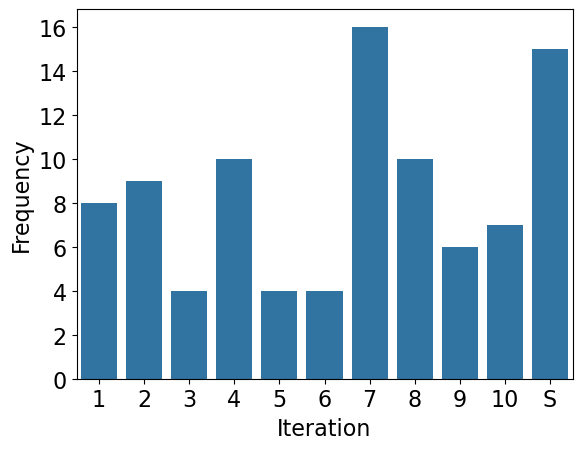

In [24]:
plot_results_dict(results_dict)

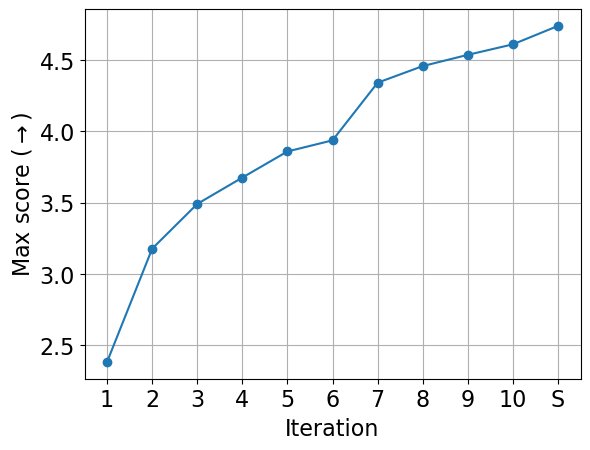

In [25]:
plot_scores_cummax(scores_cummax_matrix)

# ResNet-50

In [26]:
scores_cummax_matrix, results_dict = process_results(RESNET50_PATH)

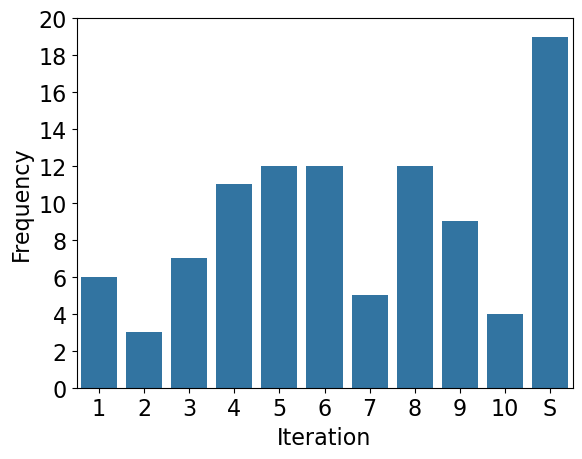

In [27]:
plot_results_dict(results_dict)

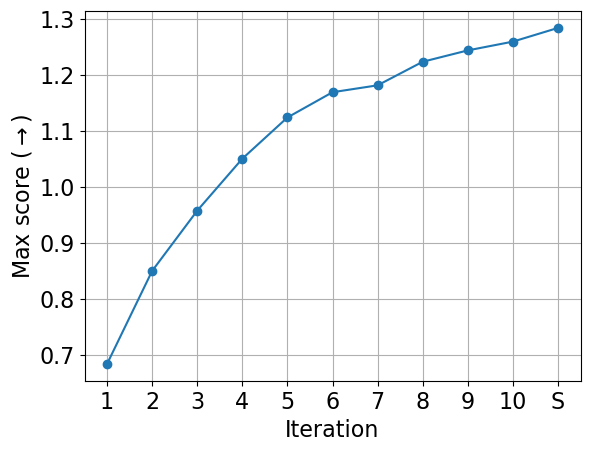

In [28]:
plot_scores_cummax(scores_cummax_matrix)